# Experiment setup

In [1]:
import numpy as np
import json
import math
import glob
import os
import pandas as pd
import google.protobuf
from collections import Counter
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import math
from numpy import linalg as LA
import statistics

configure the building name and floor level for the experiment

In [172]:
buildingname =  'IAHS'
floorlevel =  2

The location labels are GPS coordinates, to make it easier for experimentation and data visualization, the reference point (origin) is used to create a local coordinate system. The origin is selected as the south-west corner of each building.

In [173]:
import Data_pb2
from Utils import distance,offset_coord,gps_fromxy,gps2local,get_file_list,load_data_packs,location_interpolate
from Utils import parse_path_packages,parse_point_packages

#load building information
with open('building_dict.json') as fin:
    building_dict = json.load(fin)

#find a reference gps location for a local coordinate system
gpspo = np.array(building_dict[buildingname]['gpspo'])
gps_origin=tuple(np.min(gpspo,axis=0))

# Data Package Loading
Load the data which are stored following the Google protobuf format in a package. 

In [174]:
#Load the data packages
data_folder = os.path.join('FpData',buildingname,str(floorlevel))
print('The data folder is in:',data_folder)
#1. Load path-based data and verify the building and floor level
path_packages = []
path_data_files = get_file_list(data_folder, 1)
if len(path_data_files)>0:
    path_packages = load_data_packs(path_data_files)
    for i,path_package in enumerate(path_packages):
        assert path_package.buildingName==buildingname, "building mismatch, delete file and retry: "+path_data_files[i]
        assert int(path_package.floorLevel)==int(floorlevel), "floor mismatch, delete fine and retry:"+path_data_files[i]
print('The number of path-based collection',len(path_packages))
print(path_data_files)
#2. Load the point-based data and verify the building and floor level
point_packages = []
point_data_files = get_file_list(data_folder, 2)
if len(point_data_files)>0:
    point_packages = load_data_packs(point_data_files)
    for i,point_package in enumerate(point_packages):
        assert point_package.buildingName==buildingname, "building  mismatch,delete file and retry:"+point_data_files[i]
        assert int(point_package.floorLevel)==int(floorlevel), "floor  mismatch,delete file and retry:"+point_data_files[i]
print('The number of point-based collection',len(point_packages))

#3. Load the test data
test_packages = []
test_data_files = get_file_list(os.path.join('FpData',buildingname,str(floorlevel),'test'), 2)
if len(test_data_files)>0:
    test_packages = load_data_packs(test_data_files)
    for test_package in point_packages:
        assert test_package.buildingName==buildingname, "building name mismatch"
        assert test_package.floorLevel==floorlevel, "floor level mismatch"
print('The number of test points',len(test_packages))


The data folder is in: FpData/IAHS/2
The number of path-based collection 3
['/Users/lawrence/Desktop/IPS_liu433/IPS2/FpData/IAHS/2/liu433_1_20190901131209.pbf', '/Users/lawrence/Desktop/IPS_liu433/IPS2/FpData/IAHS/2/liu433_1_20190901130655.pbf', '/Users/lawrence/Desktop/IPS_liu433/IPS2/FpData/IAHS/2/liu433_1_20190901130804.pbf']
The number of point-based collection 30
The number of test points 0


In [175]:
# APs seen by less than this value will be ignored.
Freq_threshold = 35

#Select the Effective Access Points since some Access Points may just temporary
AP_bssids = []
for pack in point_packages:
    for e in pack.rssItems:
        AP_bssids.append(e.bssid)
for pack in path_packages:
    for e in pack.rssItems:
        AP_bssids.append(e.bssid)
AP_bssids_count = dict(Counter(AP_bssids))
#remove APs only seen sporadically. 
AP_bssids_common = {k:v for k,v in AP_bssids_count.items() if v > Freq_threshold}
#create a dict for the AP_bssid index for convenience to organize the fingerprint vector
AP_bssids_index_dict = {k:v for k,v in zip(AP_bssids_common.keys(),range(len(AP_bssids_common)))}

if len(AP_bssids_index_dict)<3:
    print('Error, AP_bssids_index_dict is too small and try to set Freq_threshold to a smaller value')

# Data Package Parse

In [176]:
path_FPs, path_labels = parse_path_packages(path_packages,AP_bssids_index_dict)
point_FPs, point_labels = parse_point_packages(point_packages,AP_bssids_index_dict)
test_FPs, test_labels = parse_point_packages(test_packages,AP_bssids_index_dict)
local_poly = [offset_coord(gps_origin[1],gps_origin[0],lat,lon) for lon,lat in gpspo]

# check the shape of the data sets
print (len(path_FPs))
print (len(path_FPs[0]))
print (len(point_FPs))
print (len(point_FPs[0]))

path length is 57.241023 meter
path length is 56.485961 meter
path length is 56.913327 meter
27
5
30
5


Locations Visualization

In [177]:
def data_process_visualization(local_poly,ground_true,final_result,filename):
    x_scale,y_scale=np.max(local_poly,axis=0) - np.min(local_poly,axis=0)
    fig, ax = plt.subplots(1, 1, figsize=(x_scale*0.15,y_scale*0.15)) 
    local_poly = np.array(local_poly)
    ax.plot(*zip(*local_poly))
    ax.scatter(ground_true[:,-2],ground_true[:,-1],c='r',marker='o',label="Ground Truth")
    #ax.scatter(y_train[10:20,0],y_train[10:20,1],c='b',marker='o',label="Unlabelled Data")
    ax.scatter(final_result[:,-2],final_result[:,-1],c='black',marker='o',label="Estimated Data")
    # ax.scatter(lo,la,c='black',marker='*',label="Predicte Result for test data")
    ax.legend()
    plt.savefig("10_{}_propagation_plot.png".format(filename))
    plt.show()

In [178]:
def vis(test_loc,lo,la,apa):
    local_poly = [offset_coord(gps_origin[1],gps_origin[0],lat,lon) for lon,lat in gpspo]
    x_scale,y_scale=np.max(local_poly,axis=0) - np.min(local_poly,axis=0)
    fig, ax = plt.subplots(1, 1, figsize=(x_scale*0.15,y_scale*0.15)) 
    local_poly = np.array(local_poly)
    ax.plot(*zip(*local_poly))
    ax.scatter(test_loc.iloc[:,-2],test_loc.iloc[:,-1],c='b',marker='o',label="Test data")
    ax.scatter(train_locs[:10,0],train_locs[:10,1],c='r',marker='o',label="Labelled Data")
    ax.scatter(lo,la,c='black',marker='o',label="Estimated Data")
    # ax.scatter(lo,la,c='black',marker='*',label="Predicte Result for test data")
    ax.legend()
    plt.savefig("10_{}_gps_plot.png".format(apa))
    plt.show()

# Label Propagation

In [179]:
"""Followings are functions used to calalated 
differet component of the equation for the DG-SSL.
"""
def similarity_matrix(fp,row,t):
    w = [] 
    for i in range(row):
        w.append([])
        for j in range(row):
            temp = math.exp(-LA.norm(fp[i] - fp[j], 2)/t)
            w[i].append(temp)
    return w

def distance_matrix(fp,row,col,a,b):
    d = []
    for i in range(row):
        d.append([])
        for j in range(row):
            temp = []
            for m in range(col):
                v1 = (fp[i][m] - fp[j][m])/(10*a)
                v2 = abs(pow(10, v1) - 1)
                v3 = v2 * pow(10,(fp[i][m]-b)/(-10*a))
                temp.append(v3)
            #d[i].append(max(temp))
            d[i].append(statistics.median(temp))
    return d

def laplace_matrix(row,w):
    u = []
    for i in range(row):
        u.append(sum(w[i]))
    D = np.diag(u)
    L = D - w
    return L

def k_matrix(row,w,d):
    k = []
    for i in range(row):
        k.append([])
        for j in range(row):
            k[i].append(w[i][j]*d[i][j])
    k = np.array(k)
    return k

def update_g(result,row,G,k):
    for i in range(row):
        g = np.array([0]*2,dtype=float).reshape(2)
        for j in range(row):
            if (i != j): 
                v1 = result[:,i] - result[:,j]
                v2 = LA.norm(v1,1)
                g = g + (k[i][j] * (v1/v2))
        G[:,i] = g
    return G

In [180]:
# convert the location labels to the local coordinator
path_locs = gps2local(gps_origin,path_labels)
point_locs = gps2local(gps_origin,point_labels)
test_locs = gps2local(gps_origin,test_labels)
train_data = np.array(path_FPs + point_FPs)
train_locs = np.array(path_locs + point_locs)

# save the raw data set
raw_data = np.append(train_data,train_locs,axis=1)
pd.DataFrame(raw_data).to_csv("IHAS_2nd_dataset.csv",
                              header=["ap1","ap2","ap3","ap4","ap5","long","lat"],
                              index=None)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_locs, test_size=0.2,random_state=1)
print('Training data shape:',X_train.shape) #(45, 5)
print('Test data shape:',X_test.shape) #(12, 5)


Training data shape: (45, 5)
Test data shape: (12, 5)


Shape of labeled data: (10, 7)
Shape of unlabeled data: (10, 7)
Plot for the data propagation results of 10 unlabeled data:


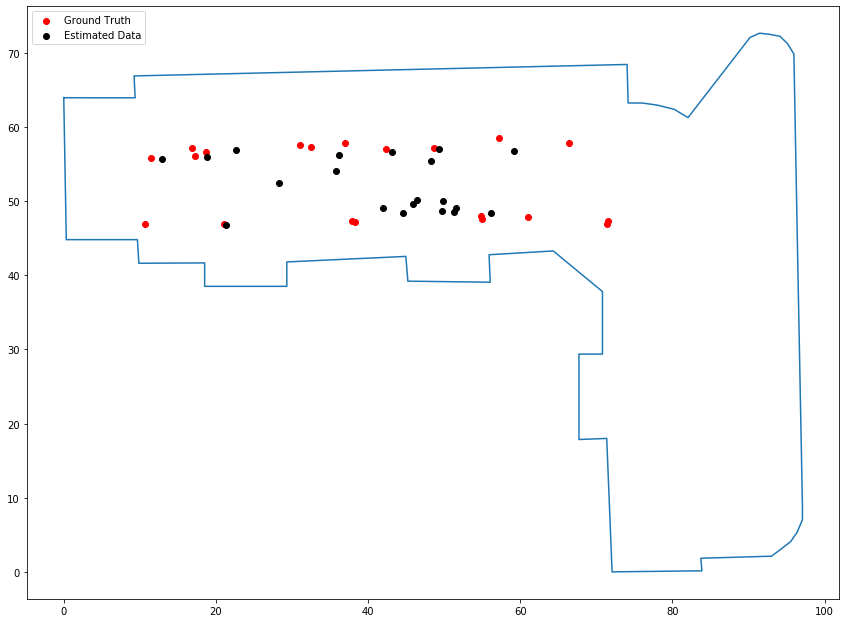





Shape of labeled data: (10, 7)
Shape of unlabeled data: (20, 7)
Plot for the data propagation results of 20 unlabeled data:


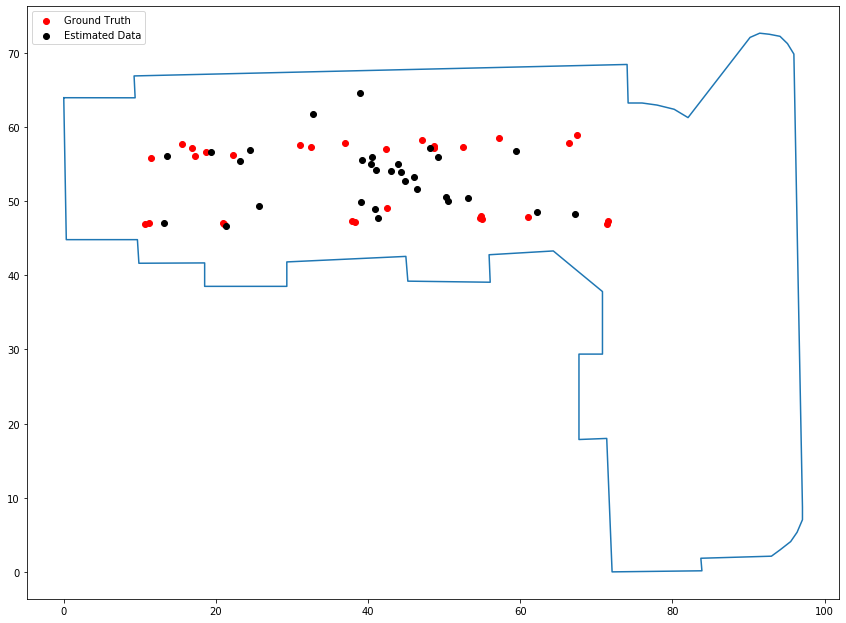





Shape of labeled data: (10, 7)
Shape of unlabeled data: (30, 7)
Plot for the data propagation results of 30 unlabeled data:


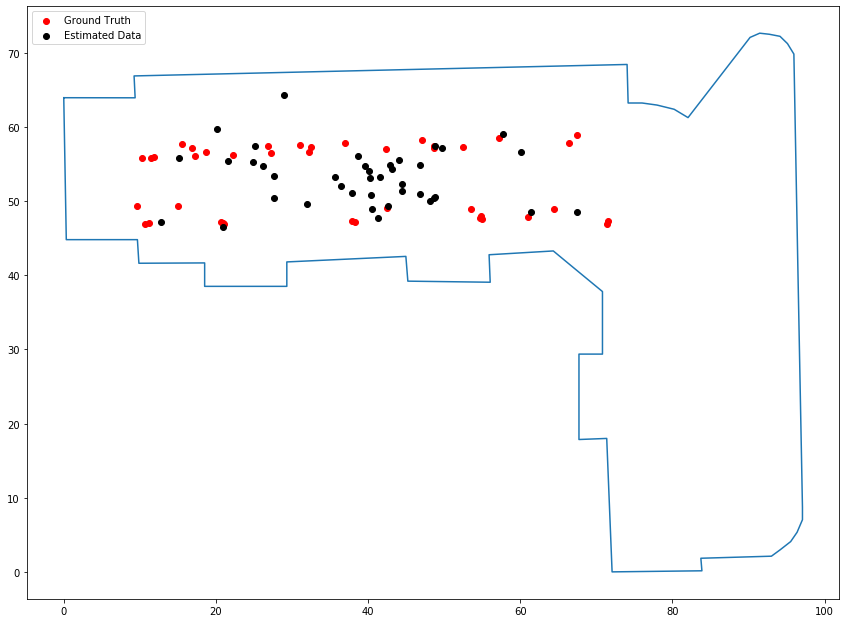

In [181]:
for number_of_unlabeled_data in [10,20,30]:
    df_labeled_np = np.append(X_train[:10],y_train[:10],axis=1)
    df_unlabeled_np = np.append(X_train[10:number_of_unlabeled_data+10],
                                y_train[10:10+number_of_unlabeled_data],
                                axis=1)

    print ("Shape of labeled data: " + str(df_labeled_np.shape))
    print ("Shape of unlabeled data: " + str(df_unlabeled_np.shape))

    # dimenstion measurement
    dimension_ul = df_unlabeled_np.shape
    dimension_l = df_labeled_np.shape
    label_and_unlabel = np.concatenate((df_labeled_np,df_unlabeled_np))
    dimension_t = label_and_unlabel.shape

    loc = label_and_unlabel[:,dimension_t[1]-2:] # location 
    fp = label_and_unlabel[:,:dimension_t[1]-2] # rssi 
    row = dimension_t[0] 
    col = dimension_t[1]-2

    t = dimension_ul[0] # number of unlabeled data

    w = similarity_matrix(fp,row,10)
    a = 3.5 # parameters for distance_matrix function 3.5
    b = -30 # parameters for distance_matrix function
    d = distance_matrix(fp, row, col, a, b)

    L = laplace_matrix(row,w)
    k = k_matrix(row,w,d)

    J = [1]*(t) + [0]*(row-t)
    J = np.diag(J)

    G = np.array([0]*row*2,dtype=float).reshape(2,row)
    loc_transpose = np.transpose(loc)

    # iterate until converge
    r = 1

    for i in range(300):
        first_part_eq = np.dot(loc_transpose,J) + (r*G)
        second_part_eq = np.linalg.inv(J + r*L)
        predicted_result = np.dot(first_part_eq,second_part_eq)
    #     print (predicted_result)
        G = update_g(predicted_result,row,G,k)

    # Saved the propergation result to a csv file 
    predicted_result = np.transpose(predicted_result)
    final_result = np.concatenate((fp,predicted_result), axis=1)
    print ("Plot for the data propagation results of {} unlabeled data:".format(number_of_unlabeled_data))
    data_process_visualization(local_poly,y_train[:number_of_unlabeled_data+10],
                               final_result,number_of_unlabeled_data)
    final_result = np.append(df_labeled_np,final_result[10:],axis=0)
    pd.DataFrame(final_result).to_csv('propagation_results_10_{}.csv'.format(number_of_unlabeled_data),
                                      index=None,header=None)
    print ("\n\n\n")
    

# Localization models training and performance evaluation

In [182]:
import importlib

In [183]:
import gps_deployment.gps_starting as gps
import gps_deployment.main_controller as gps1
import gps_deployment.gaussian as gps2

In [184]:
importlib.reload(gps)
importlib.reload(gps1)
importlib.reload(gps2)

<module 'gps_deployment.gaussian' from '/Users/lawrence/Desktop/IPS_liu433/IPS2/gps_deployment/gaussian.py'>

In [185]:
training_files = [["10_training_data.csv",0],
                  ["propagation_results_10_10.csv",10],
                  ["propagation_results_10_20.csv",20],
                  ["propagation_results_10_30.csv",30]]

Train GPs

10_training_data.csv
10_training_data.csv
(20, 7)
Gaussian Process #0
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #1
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #2
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #3
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #4
Training with Hyperparameters [8, 2, 0.5]


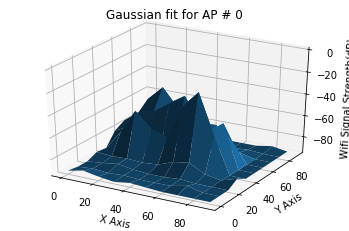

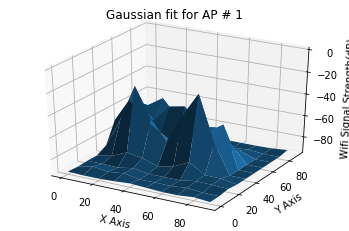

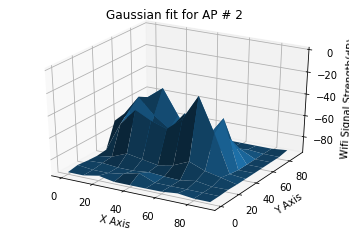

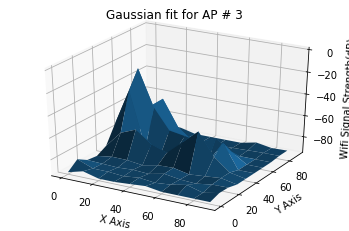

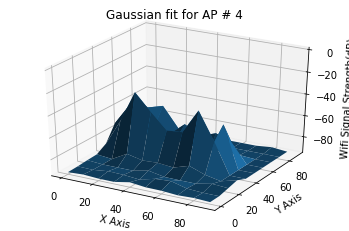

(5, 275)
275
propagation_results_10_10.csv
propagation_results_10_10.csv
(20, 7)
Gaussian Process #0
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #1
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #2
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #3
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #4
Training with Hyperparameters [8, 2, 0.5]


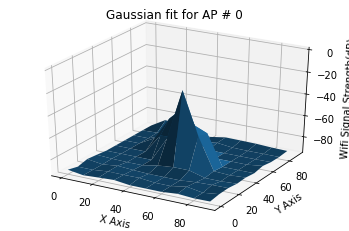

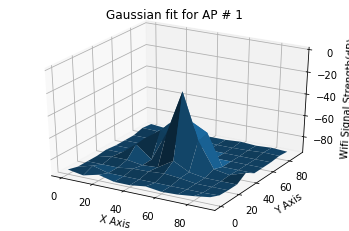

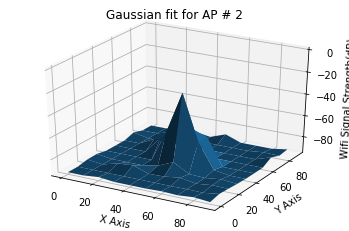

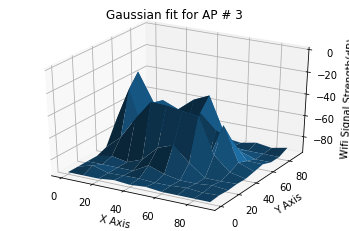

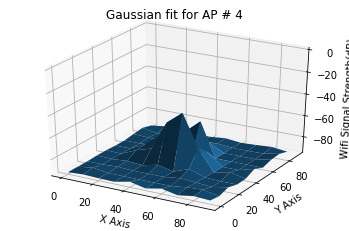

(5, 500)
475
propagation_results_10_20.csv
propagation_results_10_20.csv
(30, 7)
Gaussian Process #0
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #1
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #2
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #3
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #4
Training with Hyperparameters [8, 2, 0.5]


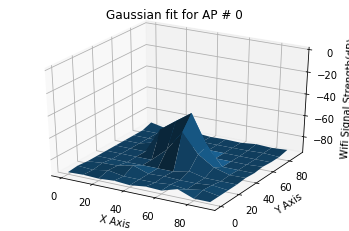

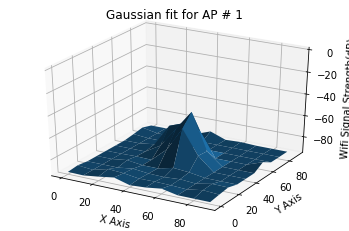

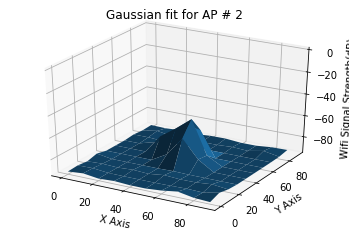

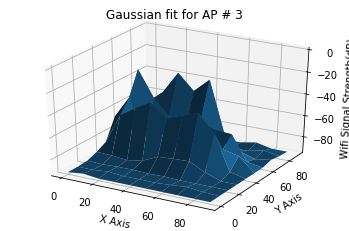

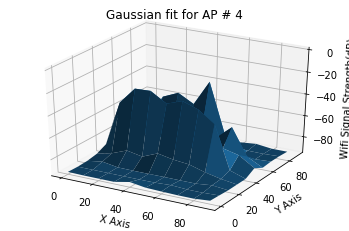

(5, 750)
750
propagation_results_10_30.csv
propagation_results_10_30.csv
(40, 7)
Gaussian Process #0
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #1
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #2
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #3
Training with Hyperparameters [8, 2, 0.5]
Gaussian Process #4
Training with Hyperparameters [8, 2, 0.5]


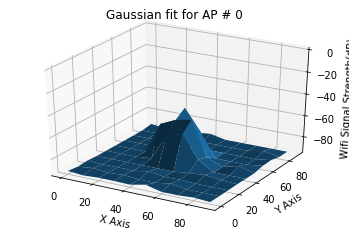

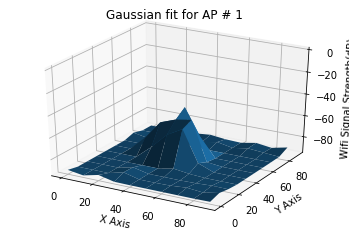

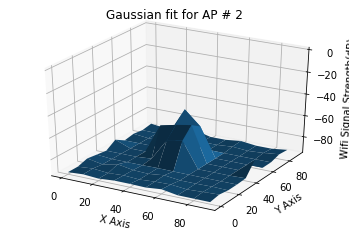

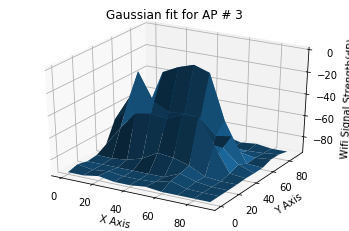

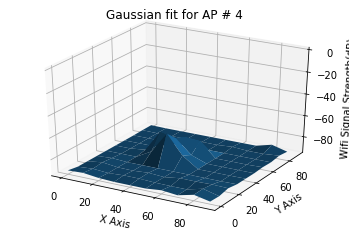

(5, 1000)
975


In [186]:
for i in training_files:
#     print (i)
    gps.gps_start(i[0],i[1])

loading test data

In [187]:
test_data_12 = pd.read_csv("12_test_data.csv",header=None)
test_data_12.shape
test_fps = test_data_12.iloc[:,:-2]
test_loc = test_data_12.iloc[:,-2:]

In [188]:
fingerprint_map_files=["fingerprint_map_10_0.txt",
                       "fingerprint_map_10_10.txt",
                       "fingerprint_map_10_20.txt",
                       "fingerprint_map_10_30.txt"]

summary_of_localization_error = []

# Performance Evaluation 

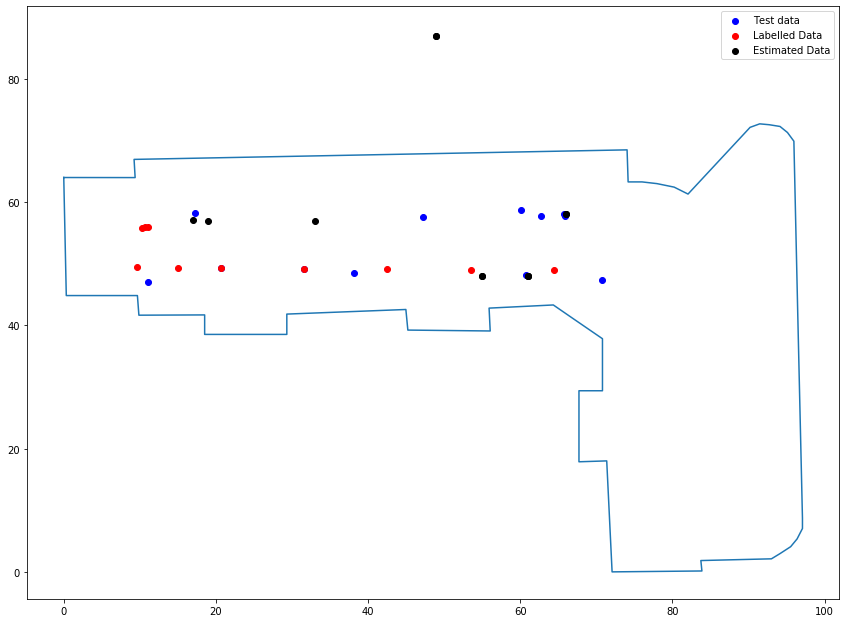

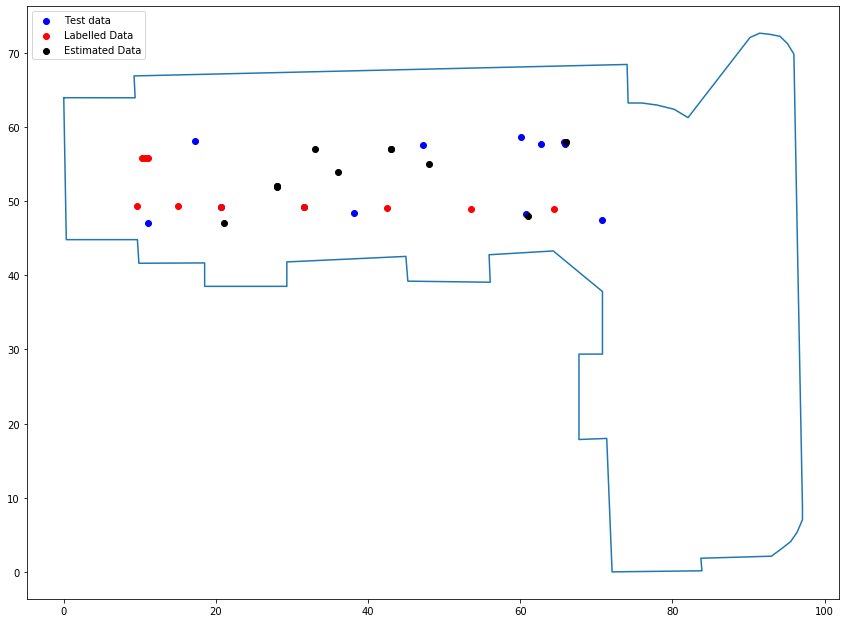

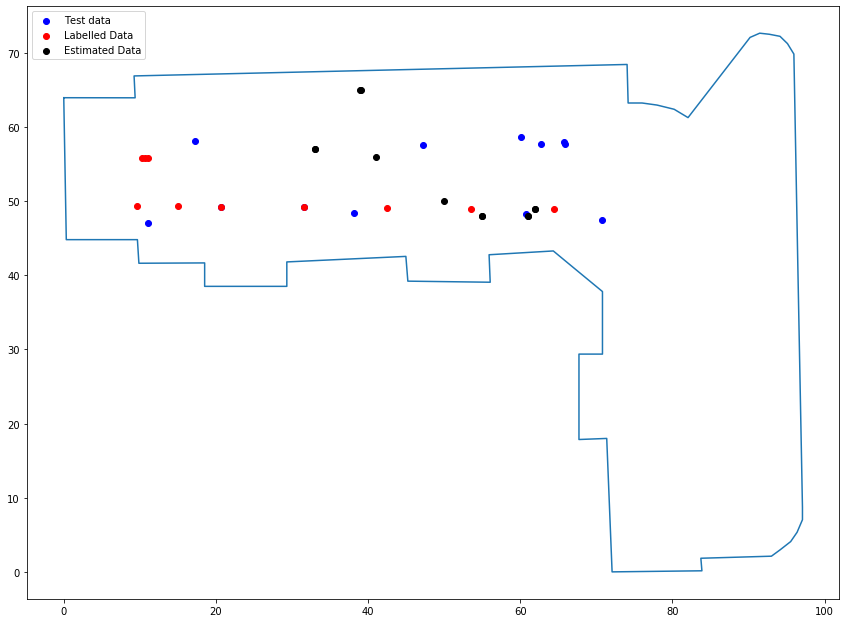

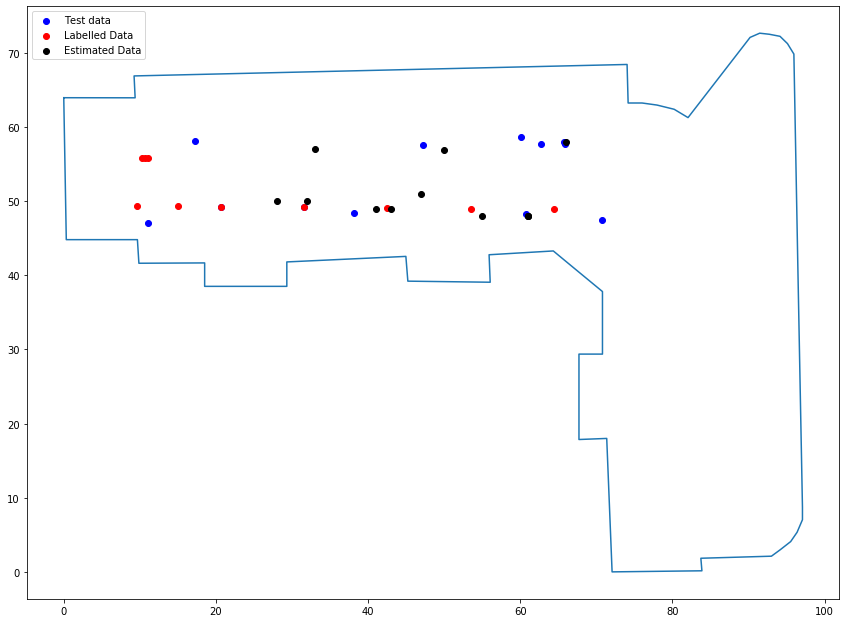

In [189]:
apa = 0
gps_errors = []
for fingerprint_map in fingerprint_map_files:
    apa = apa + 10
    with open(fingerprint_map, "r") as read_file:
            fingerprint = json.load(read_file)
    results =[]
    errors = []
    for test_index in range(test_data_12.shape[0]):
        minn = 100
        counter = 0
        test_fp = test_fps.iloc[test_index]
        for i in range(len(fingerprint['result'])):
            rss =  fingerprint['result'][i]['rssi']
            tmp = np.linalg.norm(rss-test_fp)
            if tmp < minn:
                minn = tmp
                counter = i
                # result
        result = fingerprint['result'][counter]['loc'] 
        predicted_result = {
            'long': result[0],
            'lati': result[1]
            }
        errors.append(math.sqrt((test_loc.iloc[test_index,0] - predicted_result['long'])**2 
                                + (test_loc.iloc[test_index,1] - predicted_result['lati'])**2))
        results.append(predicted_result)
    lo = list(i['long'] for i in results)
    la = list(i['lati'] for i in results)
    vis(test_loc,lo,la,apa)
#     print (statistics.median(errors))
    gps_errors.append(statistics.median(errors))

In [190]:
import downstream_models.localization_models as models
importlib.reload(models)

<module 'downstream_models.localization_models' from '/Users/lawrence/Desktop/IPS_liu433/IPS2/downstream_models/localization_models.py'>

In [191]:
files = [["10_training_data.csv",0],
            ["propagation_results_10_10.csv",10],
            ["propagation_results_10_20.csv",20],
            ["propagation_results_10_30.csv",30]]
knn_errors = []
rf_errors = []
df_errors = []
for f in files:
    print (str(f))
    training_data = pd.read_csv(f[0], header=None)
    test_data = pd.read_csv("12_test_data.csv",header=None)
    x_train = training_data.iloc[:,:5].to_numpy()
    x_test= test_data.iloc[:,:5].to_numpy()
    y_train = training_data.iloc[:,-2:]
    y_test = test_data.iloc[:,-2:]

    data_in =  (x_train, x_test, y_train, y_test)
    model_name, regr = models.load_KNN()
    error, prediction = models.run_model(model_name, regr, data_in)
#     vis(y_test,prediction[:,0],prediction[:,1],apa)
    print ("10 labeled data & {} unlabeled data".format(f[1]))
    print ("Knn error(m) - "+ str(error))
    knn_errors.append(error)
    model_name, regr= models.load_Random_Forest()
    error,prediction = models.run_model(model_name, regr, data_in)
    print ("Random Forest error(m)- "+ str(error))
    rf_errors.append(error)
    model_name, regr= models.load_Decision_Tree()
    error,prediction = models.run_model(model_name, regr, data_in)
    print ("Decision Tree error(m)- "+ str(error))
    df_errors.append(error)
    print (" ")

['10_training_data.csv', 0]
10 labeled data & 0 unlabeled data
Knn error(m) - 29.048918544212125
Random Forest error(m)- 19.375048106109052
Decision Tree error(m)- 26.17249961456477
 
['propagation_results_10_10.csv', 10]
10 labeled data & 10 unlabeled data
Knn error(m) - 18.37074375367255
Random Forest error(m)- 19.70084127193227
Decision Tree error(m)- 17.859096879454995
 
['propagation_results_10_20.csv', 20]
10 labeled data & 20 unlabeled data
Knn error(m) - 19.917235507804968
Random Forest error(m)- 16.26174435415565
Decision Tree error(m)- 11.754373154879293
 
['propagation_results_10_30.csv', 30]
10 labeled data & 30 unlabeled data
Knn error(m) - 15.327988543382062
Random Forest error(m)- 15.804160217623348
Decision Tree error(m)- 21.02247820358773
 


In [192]:
summary_of_localization_error = [gps_errors,knn_errors,rf_errors,df_errors]

In [193]:
summary_of_localization_error = pd.DataFrame(summary_of_localization_error,index=['GPs','Knn','Rf','Df'],columns=["0 unlabel data","10 unlabel data","20 unlabel data","30 unlabel data"])

In [194]:
summary_of_localization_error

,0 unlabel data,10 unlabel data,20 unlabel data,30 unlabel data
GPs,29.414602,26.069927,19.884801,13.100275
Knn,29.048919,18.370744,19.917236,15.327989
Rf,19.375048,19.700841,16.261744,15.804160
Df,26.172500,17.859097,11.754373,21.022478
